<a href="https://colab.research.google.com/github/aravindchakravarti/Deep_Learning_EVA_4/blob/master/S12_TinyImageNet/S12A/S12_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up Google Drive and Libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# to autoreload all the custom files when modified
import autoreload
%load_ext autoreload
%autoreload 2

In [0]:
# All the supporting python files are saved in GDrive
import sys
sys.path.append('./gdrive/My Drive/EVA_Library/')

In [4]:
!pip install --no-cache-dir git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-i11cjtm4
Albumentation library is successfully installed!


In [5]:
from pyTorchChitra.datasets.dataset_loader import getCifar10Data, tiny_imagenet_with_albumentations
from pyTorchChitra.cnnModels.resnet18 import ResNet18
from pyTorchChitra.cnnModels.model_summary import displayModelSummary
from pyTorchChitra.modelTraining.modelTraining import setup_ROP_Optimizer, runTheModel, modelTrainTestHistory
from pyTorchChitra.modelTraining.modelTraining import setup_OCLR_Optimizer
from pyTorchChitra.utils.utils import isCudaAvailable
from pyTorchChitra.modelTraining.lrFinder import LRFinder
from pyTorchChitra.gradCAM.visual import GradCAMView, plot_gradcam
from pyTorchChitra.utils.misClassfiedImages import misClassfied, displayMisClassfiedImages
from pyTorchChitra.datasets.displayImages import displayDataSetSampleImages
!pip install torchsummary
#!pip install -U git+https://github.com/albu/albumentations


  pip install torch-lr-finder -v --global-option="amp"


# Set the Arguments for project and Setup Train/Test Dataset 

In [0]:
# Arguments for the functions
class Args:
    # ---- Data Loader Arguments -----
    train_batch_size = 512
    test_batch_size = 512
    num_workers = 4
    dataset_mean = [0.4802, 0.4481, 0.3975]
    dataset_std = [0.2302, 0.2265, 0.2262]
    classes = []

class modelExtraSettings:
    '''Additional setting which are useful when debugging model '''
    RunLRFinder = False
    display_summary = True  

In [7]:
# Get the Cifar-10 dataset and apply Ablumentation image augmentation techniques
train_loader, test_loader = tiny_imagenet_with_albumentations(
                            batch_size = Args.train_batch_size, 
                            number_of_workers = Args.num_workers,
                            prob_transform = Args.num_workers  
                            )

Now downloading and allocating dataset
Cuda Available? cuda
Now allocating Dataloaders


In [0]:
for batch_idx, (data, target) in enumerate (test_loader):
    print (target)
    break

In [0]:
# Display the sample images. Images will be saved in current directory

displayDataSetSampleImages(train_loader, Args.classes,
                           Args.dataset_mean, Args.dataset_std, 
                           num_of_images = 20)

torch.Size([512, 32, 32, 3])


<Figure size 720x720 with 0 Axes>

# Train the Model

In [8]:
device = isCudaAvailable()
print (device)

cuda


In [0]:
#from pyTorchChitra.cnnModels.vanillaCNN import plainArch

In [9]:
model = ResNet18().to(device)
if modelExtraSettings.display_summary == True:
    displayModelSummary(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

./gdrive/My Drive/EVA_Library/pyTorchChitra/cnnModels/resnet18.py:89: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


In [0]:
import torch.nn as nn
from torch.optim import SGD, Adam

if modelExtraSettings.RunLRFinder == True:
    criterion = nn.NLLLoss()
    optimizer = SGD(model.parameters(), lr=0.001)
    lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
    lr_finder.range_test(train_loader, end_lr=1, num_iter=500, step_mode="exp")


./gdrive/My Drive/EVA_Library/pyTorchChitra/cnnModels/resnet18.py:89: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)



Learning rate search finished. See the graph with {finder_name}.plot()


1.0139113857366795


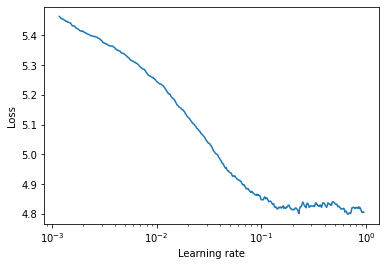

In [0]:
if modelExtraSettings.RunLRFinder == True:
    lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
    print (lr)
    lr_finder.plot()

In [0]:
optimizer, scheduler = setup_OCLR_Optimizer(model, device, total_steps = 5880, 
                                            num_raise = 0.3, div_factor = 10, max_lr = 0.01)

In [13]:
for param_group in optimizer.param_groups:
    print(param_group['lr'])

0.001


In [14]:
train_losses, train_acc, test_losses, test_acc = runTheModel(model=model, 
                                                            device=device, 
                                                            optimizer=optimizer, 
                                                            train_loader=train_loader, 
                                                            test_loader=test_loader, 
                                                            scheduler=scheduler,
                                                            epochs = 40, 
                                                            isOCLR = True,
                                                            )


  0%|          | 0/196 [00:00<?, ?it/s]

EPOCH: 0


./gdrive/My Drive/EVA_Library/pyTorchChitra/cnnModels/resnet18.py:89: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
Loss=4.844517707824707 Batch_id=195 Accuracy=2.96: 100%|██████████| 196/196 [06:21<00:00,  1.94s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 4.7989, Accuracy: 254/5000 (5.08%)
Validation loss to Schedular = 4.798869799804687

EPOCH: 1


Loss=4.391465663909912 Batch_id=195 Accuracy=6.85: 100%|██████████| 196/196 [06:21<00:00,  1.95s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 4.4670, Accuracy: 411/5000 (8.22%)
Validation loss to Schedular = 4.466952685546875

EPOCH: 2


Loss=4.199827194213867 Batch_id=195 Accuracy=10.38: 100%|██████████| 196/196 [06:21<00:00,  1.95s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 4.2645, Accuracy: 549/5000 (10.98%)
Validation loss to Schedular = 4.264459106445313

EPOCH: 3


Loss=3.95682954788208 Batch_id=195 Accuracy=13.09: 100%|██████████| 196/196 [06:21<00:00,  1.95s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 4.1447, Accuracy: 624/5000 (12.48%)
Validation loss to Schedular = 4.1446908203125

EPOCH: 4


Loss=3.900290012359619 Batch_id=195 Accuracy=15.39: 100%|██████████| 196/196 [06:23<00:00,  1.96s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 4.0630, Accuracy: 698/5000 (13.96%)
Validation loss to Schedular = 4.063024975585938

EPOCH: 5


Loss=3.6133015155792236 Batch_id=195 Accuracy=17.11: 100%|██████████| 196/196 [06:23<00:00,  1.96s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 3.9848, Accuracy: 709/5000 (14.18%)
Validation loss to Schedular = 3.9847953857421876

EPOCH: 6


Loss=3.687138319015503 Batch_id=195 Accuracy=18.84: 100%|██████████| 196/196 [06:23<00:00,  1.96s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 3.7865, Accuracy: 869/5000 (17.38%)
Validation loss to Schedular = 3.7865423828125

EPOCH: 7


Loss=3.600386381149292 Batch_id=195 Accuracy=20.80: 100%|██████████| 196/196 [06:23<00:00,  1.96s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 3.7490, Accuracy: 941/5000 (18.82%)
Validation loss to Schedular = 3.7490255126953125

EPOCH: 8


Loss=3.2851061820983887 Batch_id=195 Accuracy=22.32: 100%|██████████| 196/196 [06:23<00:00,  1.96s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 3.7738, Accuracy: 929/5000 (18.58%)
Validation loss to Schedular = 3.773811474609375

EPOCH: 9


Loss=3.409442186355591 Batch_id=195 Accuracy=23.80: 100%|██████████| 196/196 [06:23<00:00,  1.96s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 3.6078, Accuracy: 1011/5000 (20.22%)
Validation loss to Schedular = 3.60782021484375

EPOCH: 10


Loss=3.29036283493042 Batch_id=195 Accuracy=25.12: 100%|██████████| 196/196 [06:23<00:00,  1.95s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 3.5704, Accuracy: 1083/5000 (21.66%)
Validation loss to Schedular = 3.5703529052734373

EPOCH: 11


Loss=3.3736863136291504 Batch_id=195 Accuracy=26.54: 100%|██████████| 196/196 [06:23<00:00,  1.96s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 3.4618, Accuracy: 1159/5000 (23.18%)
Validation loss to Schedular = 3.4618148681640624

EPOCH: 12


Loss=3.2038681507110596 Batch_id=195 Accuracy=27.42: 100%|██████████| 196/196 [06:23<00:00,  1.95s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 3.3690, Accuracy: 1233/5000 (24.66%)
Validation loss to Schedular = 3.36897998046875

EPOCH: 13


Loss=3.2627646923065186 Batch_id=195 Accuracy=28.79: 100%|██████████| 196/196 [06:23<00:00,  1.95s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 3.3111, Accuracy: 1319/5000 (26.38%)
Validation loss to Schedular = 3.3111258056640627

EPOCH: 14


Loss=3.2689521312713623 Batch_id=195 Accuracy=29.86: 100%|██████████| 196/196 [06:22<00:00,  1.95s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 3.2464, Accuracy: 1305/5000 (26.10%)
Validation loss to Schedular = 3.246447412109375

EPOCH: 15


Loss=3.177945613861084 Batch_id=195 Accuracy=30.58: 100%|██████████| 196/196 [06:23<00:00,  1.96s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 3.2678, Accuracy: 1293/5000 (25.86%)
Validation loss to Schedular = 3.267813671875

EPOCH: 16


Loss=2.9659059047698975 Batch_id=195 Accuracy=31.73: 100%|██████████| 196/196 [06:22<00:00,  1.95s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 3.1466, Accuracy: 1474/5000 (29.48%)
Validation loss to Schedular = 3.146611181640625

EPOCH: 17


Loss=3.0235095024108887 Batch_id=195 Accuracy=32.38: 100%|██████████| 196/196 [06:22<00:00,  1.95s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 3.1782, Accuracy: 1448/5000 (28.96%)
Validation loss to Schedular = 3.1782220458984374

EPOCH: 18


Loss=3.192631721496582 Batch_id=195 Accuracy=33.17: 100%|██████████| 196/196 [06:24<00:00,  1.96s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 3.1886, Accuracy: 1417/5000 (28.34%)
Validation loss to Schedular = 3.188637841796875

EPOCH: 19


Loss=2.825874090194702 Batch_id=195 Accuracy=34.00: 100%|██████████| 196/196 [06:24<00:00,  1.96s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 3.0371, Accuracy: 1521/5000 (30.42%)
Validation loss to Schedular = 3.0371004150390624

EPOCH: 20


Loss=2.7464663982391357 Batch_id=195 Accuracy=34.71: 100%|██████████| 196/196 [06:23<00:00,  1.95s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 3.0750, Accuracy: 1494/5000 (29.88%)
Validation loss to Schedular = 3.0749627685546876

EPOCH: 21


Loss=3.1026670932769775 Batch_id=195 Accuracy=35.39: 100%|██████████| 196/196 [06:22<00:00,  1.95s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 2.9976, Accuracy: 1546/5000 (30.92%)
Validation loss to Schedular = 2.9976149658203126

EPOCH: 22


Loss=2.594473361968994 Batch_id=195 Accuracy=36.16: 100%|██████████| 196/196 [06:23<00:00,  1.96s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 3.0665, Accuracy: 1505/5000 (30.10%)
Validation loss to Schedular = 3.0665242431640625

EPOCH: 23


Loss=2.607027769088745 Batch_id=195 Accuracy=36.83: 100%|██████████| 196/196 [06:24<00:00,  1.96s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 2.9933, Accuracy: 1600/5000 (32.00%)
Validation loss to Schedular = 2.9933216552734376

EPOCH: 24


Loss=2.7922611236572266 Batch_id=195 Accuracy=37.89: 100%|██████████| 196/196 [06:24<00:00,  1.96s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 2.9102, Accuracy: 1626/5000 (32.52%)
Validation loss to Schedular = 2.91017998046875

EPOCH: 25


Loss=2.6576757431030273 Batch_id=195 Accuracy=38.26: 100%|██████████| 196/196 [06:22<00:00,  1.95s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 2.9266, Accuracy: 1653/5000 (33.06%)
Validation loss to Schedular = 2.9266414794921873

EPOCH: 26


Loss=2.200917959213257 Batch_id=195 Accuracy=39.20: 100%|██████████| 196/196 [06:22<00:00,  1.95s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 2.9209, Accuracy: 1685/5000 (33.70%)
Validation loss to Schedular = 2.920860302734375

EPOCH: 27


Loss=2.64414381980896 Batch_id=195 Accuracy=39.96: 100%|██████████| 196/196 [06:21<00:00,  1.95s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 2.9333, Accuracy: 1657/5000 (33.14%)
Validation loss to Schedular = 2.93327451171875

EPOCH: 28


Loss=2.5273897647857666 Batch_id=195 Accuracy=40.66: 100%|██████████| 196/196 [06:22<00:00,  1.95s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 2.8603, Accuracy: 1731/5000 (34.62%)
Validation loss to Schedular = 2.8603188232421877

EPOCH: 29


Loss=2.6406352519989014 Batch_id=195 Accuracy=41.57: 100%|██████████| 196/196 [06:22<00:00,  1.95s/it]
  0%|          | 0/196 [00:00<?, ?it/s]

Test set: Average loss: 2.8131, Accuracy: 1754/5000 (35.08%)
Validation loss to Schedular = 2.8130781494140624

EPOCH: 30


Loss=2.4677894115448 Batch_id=0 Accuracy=43.75:   0%|          | 0/196 [00:03<?, ?it/s]

UnboundLocalError: ignored

In [0]:
import torch
torch.save(model, './gdrive/My Drive/EVA_Library/for_testing_gradCam.pth')

In [0]:
#import torch
#torch.load('./gdrive/My Drive/EVA_Library/for_testing_gradCam.pth')